# Measurement Error Mitigation
There is clear difference in result between ideal simulator and real quantum computer.<br>
This is because of the measurement error caused by various different types of noises.<br>
We have been using Qiskit Terra for building and running circuits, and Qiskit Aer for simulations.<br>
In this notebook we will use Qiskit Ignis which is a package for error mitigation.

## Build example circuit

In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

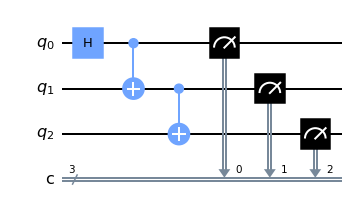

In [2]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)

circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure([0,1,2], [0,1,2])

%matplotlib inline
circuit.draw(output='mpl')

## Ideal simulation

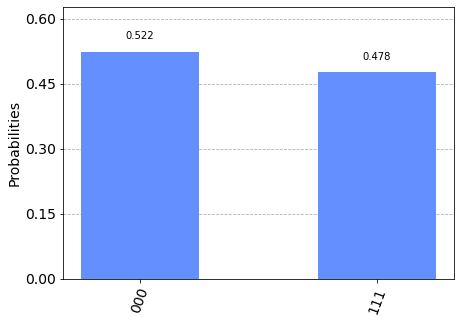

In [3]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()
sim_counts = sim_result.get_counts()
plot_histogram(sim_counts)

## Real device

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')

In [5]:
job = execute(circuit, backend=device, shots=1024)
print(job.job_id())
job_monitor(job)

60290181c3837192b42fff53
Job Status: job has successfully run


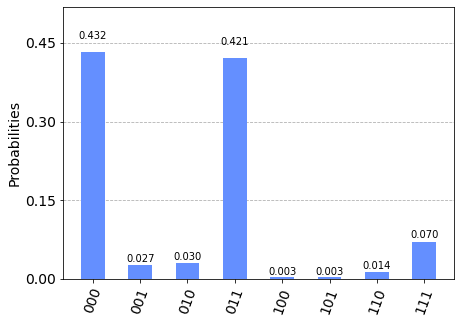

In [6]:
device_result = job.result()
device_counts = device_result.get_counts(circuit)
plot_histogram(device_counts)

## Measurement error mitigation

In [7]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [8]:
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], circlabel='measerrormitigationcal')

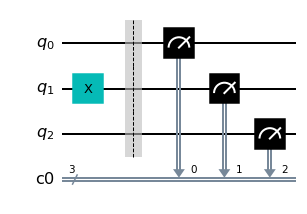

In [9]:
cal_circuits[2].draw(output='mpl')

In [10]:
len(cal_circuits)

8

In [11]:
cal_job = execute(cal_circuits, backend=device, shots=1024, optimization_level=0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

602901c2ebfc838805c01636
Job Status: job has successfully run


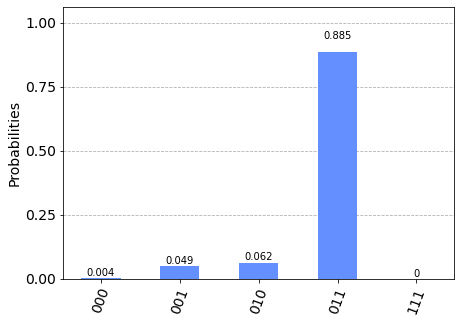

In [12]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

In [13]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

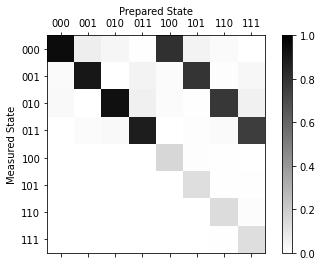

In [14]:
meas_fitter.plot_calibration()

In [15]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_result)

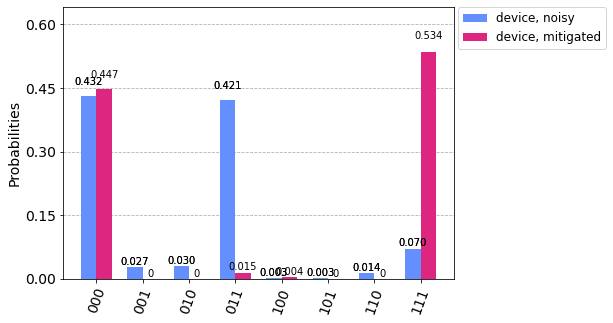

In [16]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

## One more example circuit

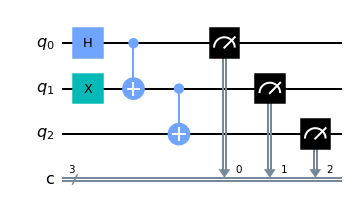

In [17]:
circuit2 = QuantumCircuit(3, 3)

circuit2.x(1)
circuit2.h(0)
circuit2.cx(0, 1)
circuit2.cx(1, 2)
circuit2.measure([0,1,2], [0,1,2])

circuit2.draw(output='mpl')

## Ideal simulation

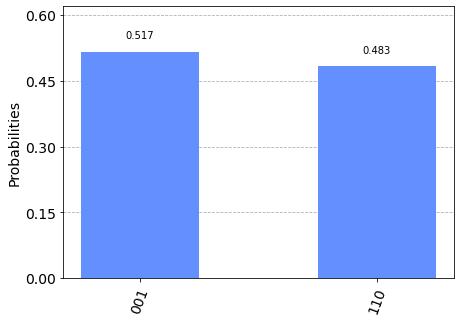

In [18]:
plot_histogram(
    execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
)

## Real Device

In [19]:
device_counts_2 = execute(circuit2, backend=device, shots=1024).result().get_counts(circuit2)

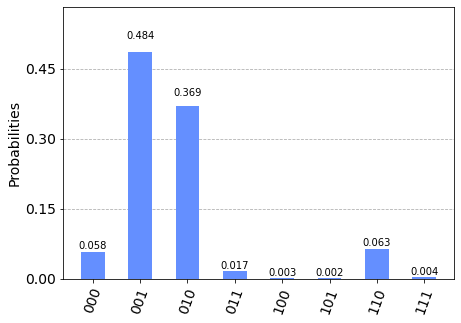

In [20]:
plot_histogram(device_counts_2)

## Measurement error mitigation

In [21]:
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

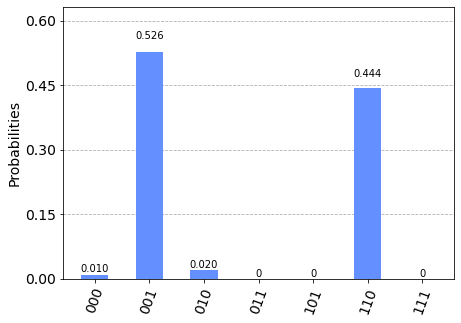

In [22]:
plot_histogram(device_mitigated_counts_2)